# CS294-158 Deep Unsupervised Learning UC Berkeley, Spring 2019

## HW1: Autoregressive Models

In [1]:
import matplotlib.pyplot as plt
from tqdm import tnrange
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Warmup

In [2]:
import torch
import torch.optim
import torch.nn.functional as F
import numpy as np
from models import WarmUpModel
from torchlib.dataset.utils import create_data_loader

Enable cuda False


In [3]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [4]:
model = WarmUpModel()

In [5]:
x = sample_data().astype(np.int64)
x_train_val = x[:8000]
x_test = x[8000:]
x_train = x_train_val[:7000]
x_val = x_train_val[7000:]
print(x_train.shape, x_val.shape, x_test.shape)

(7000,) (1000,) (2000,)


In [6]:
# hyperparamters
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
n_epoch = 50
batch_size = 100
train_data_loader = create_data_loader((x_train,), batch_size=batch_size, drop_last=False)
train_loss = []
train_loss_x = []
val_loss = []
val_loss_x = []

In [7]:
step = 0
for epoch in range(n_epoch):
    for data in train_data_loader:
        data = data[0]
        optimizer.zero_grad()
        logits = model.forward(data)
        loss = F.cross_entropy(logits, data)
        train_loss.append(loss.item() / np.log(2.))
        train_loss_x.append(step)
        loss.backward()
        optimizer.step()
        step += 1
        
    # evaluate validation loss
    with torch.no_grad():
        x_val_tensor = torch.from_numpy(x_val)
        logits = model.forward(x_val_tensor)
        loss = F.cross_entropy(logits, x_val_tensor)
        val_loss.append(loss / np.log(2.))
        val_loss_x.append(step)

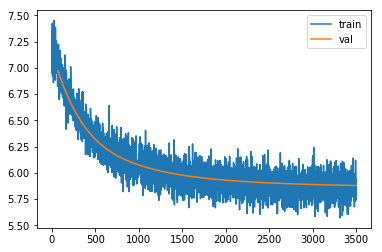

In [8]:
# plot train loss and validation loss
plt.plot(train_loss_x, train_loss, label='train')
plt.plot(val_loss_x, val_loss, label='val')
plt.legend()

In [9]:
with torch.no_grad():
    x_test_tensor = torch.from_numpy(x_test)
    test_logits = model.forward(x_test_tensor)
    nll_test = F.cross_entropy(test_logits, x_test_tensor)
    print('Negative log likelihood of testing data is {:.4f}'.format(nll_test / np.log(2.)))

Negative log likelihood of testing data is 5.8583


<BarContainer object of 100 artists>

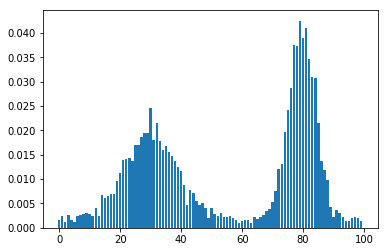

In [10]:
# Plot the model probabilities in a bar graph
plt.bar(np.arange(100), model.pmf)

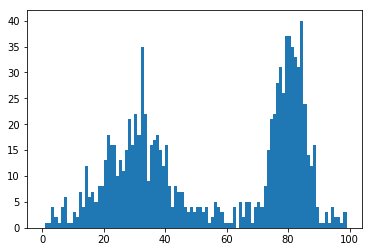

In [11]:
# draw 1000 samples
samples = model.sample(1000)
hist = plt.hist(samples, bins=np.arange(100))

### Two-dimensional data

In [12]:
# load distribution 
distribution = np.load('data/distribution.npy')
# verify that this is a valid distribution
print(np.sum(distribution), distribution.shape)

1.0 (200, 200)


In [13]:
# sample from 2d distribution
samples = np.random.choice(np.arange(np.prod(distribution.shape)), size=100000, 
                           p=distribution.reshape(-1))
x1 = samples // 200
x2 = samples - 200 * x1
x = np.stack((x1, x2), axis=-1)
print(x.shape)
x_train = x[:70000]
x_val = x[70000:80000]
x_test = x[80000:]
train_data_loader = create_data_loader((x_train,), batch_size=100, drop_last=False, shuffle=True)

(100000, 2)


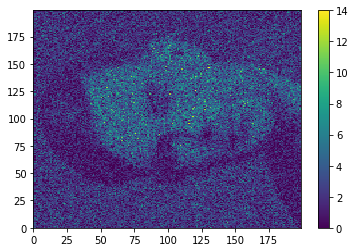

In [14]:
hist_samples = plt.hist2d(x1, x2, bins=200)
plt.colorbar(hist_samples[3])

#### Autoregressive MLP Model

In [15]:
from models import TwoDimensionModel

In [16]:
model = TwoDimensionModel()

In [17]:
# hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
n_epoch = 20
batch_size = 100
train_loss = []
train_loss_x = []
val_loss = []
val_loss_x = []

In [18]:
step = 0
for epoch in tnrange(n_epoch):
    for data in train_data_loader:
        data = data[0]
        x1 = data[:, 0]
        x2 = data[:, 1]
        optimizer.zero_grad()
        x1_logits, x2_logits = model.forward(data)
        loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
        train_loss.append(loss.item() / np.log(2.) / 2.)
        train_loss_x.append(step)
        loss.backward()
        optimizer.step()
        step += 1
        
    # evaluate validation loss
    with torch.no_grad():
        model.eval()
        x_val_tensor = torch.from_numpy(x_val)
        x1 = x_val_tensor[:, 0]
        x2 = x_val_tensor[:, 1]
        x1_logits, x2_logits = model.forward(x_val_tensor)
        loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
        val_loss.append(loss / np.log(2.) / 2.)
        val_loss_x.append(step)
        model.train()

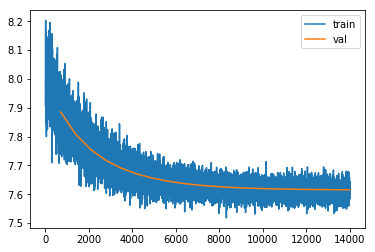

In [19]:
# plot train loss and validation loss
plt.plot(train_loss_x, train_loss, label='train')
plt.plot(val_loss_x, val_loss, label='val')
plt.legend()

In [20]:
with torch.no_grad():
    model.eval()
    x_test_tensor = torch.from_numpy(x_test)
    x1 = x_test_tensor[:, 0]
    x2 = x_test_tensor[:, 1]
    x1_logits, x2_logits = model.forward(x_test_tensor)
    loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
    print('Negative log likelihood of testing data is {:.4f}'.format(loss / np.log(2.) / 2.))
    model.train()

Negative log likelihood of testing data is 7.6134


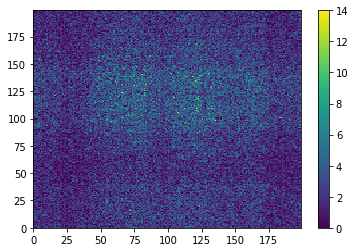

In [21]:
x1, x2 = model.sample(100000)
hist_samples = plt.hist2d(x1, x2, bins=200)
plt.colorbar(hist_samples[3])

#### Masked Autoencoder for Distribution Estimation (MADE)

In [22]:
from models import TwoDimensionMADE

In [23]:
model = TwoDimensionMADE()

In [24]:
# hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
n_epoch = 20
batch_size = 100
train_loss = []
train_loss_x = []
val_loss = []
val_loss_x = []

In [25]:
step = 0
for epoch in tnrange(n_epoch):
    for data in train_data_loader:
        data = data[0]
        x1 = data[:, 0]
        x2 = data[:, 1]
        optimizer.zero_grad()
        x1_logits, x2_logits = model.forward(data)
        loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
        train_loss.append(loss.item() / np.log(2.) / 2.)
        train_loss_x.append(step)
        loss.backward()
        optimizer.step()
        step += 1
        
    # evaluate validation loss
    with torch.no_grad():
        model.eval()
        x_val_tensor = torch.from_numpy(x_val)
        x1 = x_val_tensor[:, 0]
        x2 = x_val_tensor[:, 1]
        x1_logits, x2_logits = model.forward(x_val_tensor)
        loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
        val_loss.append(loss / np.log(2.) / 2.)
        val_loss_x.append(step)
        model.train()

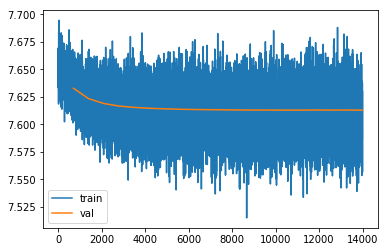

In [26]:
# plot train loss and validation loss
plt.plot(train_loss_x, train_loss, label='train')
plt.plot(val_loss_x, val_loss, label='val')
plt.legend()

In [27]:
with torch.no_grad():
    model.eval()
    x_test_tensor = torch.from_numpy(x_test)
    x1 = x_test_tensor[:, 0]
    x2 = x_test_tensor[:, 1]
    x1_logits, x2_logits = model.forward(x_test_tensor)
    loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
    print('Negative log likelihood of testing data is {:.4f}'.format(loss / np.log(2.) / 2.))
    model.train()

Negative log likelihood of testing data is 7.6111


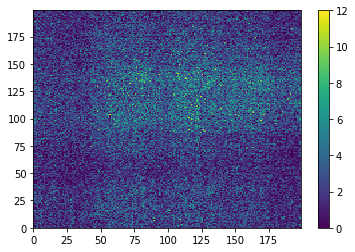

In [28]:
x1, x2 = model.sample(100000)
hist_samples = plt.hist2d(x1, x2, bins=200)
plt.colorbar(hist_samples[3])

### High-dimensional data